In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore')

# データの読込
train = pd.read_csv("./data/train_data.csv")
test = pd.read_csv('./data/test_data.csv')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/kawashima/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [2]:
change_weapon = {
    "heroblaster_replica":  "hotblaster",
    "herobrush_replica": "hokusai", 
    "herocharger_replica":  "splatcharger",
    "heromaneuver_replica":"maneuver",
    "heroroller_replica":"splatroller",
    "heroshelter_replica":"parashelter",
    "heroshooter_replica":"sshooter",
    "heroslosher_replica":"bucketslosher",
    "herospinner_replica":"barrelspinner",
    "octoshooter_replica":"sshooter"
                }

train = train.replace(change_weapon)
test = test.replace(change_weapon)

mlb = MultiLabelBinarizer()
mlb.fit([set(train['A4-weapon'].fillna("none").unique())])

MultiLabelBinarizer()

In [21]:
train.head(3)

,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,...,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
0,1,2019-10-15T20:00:00+00:00,5.0.1,regular,standard,nawabari,sumeshi,sshooter_becchu,NaN,139,...,hokusai_becchu,NaN,26.0,splatcharger,NaN,68.0,sharp_neo,NaN,31.0,1
1,2,2019-12-14T04:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,parashelter_sorella,NaN,198,...,squiclean_b,NaN,118.0,campingshelter,NaN,168.0,sputtery_clear,NaN,151.0,0
2,3,2019-12-25T14:00:00+00:00,5.0.1,gachi,standard,hoko,ama,nzap89,a-,114,...,nzap85,a+,163.0,prime_becchu,a-,160.0,dualsweeper_custom,a,126.0,0


In [4]:
print(len(train), len(test))

66125 28340


In [5]:
train.y.sum()

34696

In [6]:
def make_feature(df_train, df_test):
    train_num = len(df_train)
    df = pd.concat([df_train, df_test])
    
    
    #print(len(df))
    cat_cols = ["lobby-mode", "mode", "stage"]
    for c in cat_cols:
        vv, obj = pd.factorize(df[c])
        df[c] = vv
    #print(len(df))
    
    A1 = ['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon']
    B1 = ['B1-weapon', 'B2-weapon', 'B3-weapon', 'B4-weapon']

    t = mlb.transform(df[A1].fillna("none")[A1].values)
    t2 = mlb.transform(df[B1].fillna("none")[B1].values)
    for i in range(t.shape[1]):
        df["A-" + mlb.classes_[i]] = t[:,i]
        df["B-" + mlb.classes_[i]] = t2[:, i]
    s = ["A", "B"]
    p = ["1", "2", "3", "4"]
    for i in s:
        for j in p:
            df[i+j+"-level"] = df[i+j+"-level"]//10
            df[i+j+"-level"] = df[i+j+"-level"].clip(0,30)

        
    return df[:train_num], df[train_num:]

In [7]:
tr, te = make_feature(train, test)

feature_cols = [
     'lobby-mode', 'mode', 'stage',
]
feature_cols.extend(["A-" + i for i in mlb.classes_])
feature_cols.extend(["B-" + i for i in mlb.classes_])
print(tr.shape)

(66125, 292)


In [22]:
tr.head(3)

,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,...,A-sshooter_becchu,B-sshooter_becchu,A-sshooter_collabo,B-sshooter_collabo,A-variableroller,B-variableroller,A-variableroller_foil,B-variableroller_foil,A-wakaba,B-wakaba
0,1,2019-10-15T20:00:00+00:00,5.0.1,0,standard,0,0,sshooter_becchu,NaN,13,...,1,0,0,0,0,0,0,0,0,0
1,2,2019-12-14T04:00:00+00:00,5.0.1,0,standard,0,1,parashelter_sorella,NaN,19,...,0,0,0,0,0,0,0,0,0,0
2,3,2019-12-25T14:00:00+00:00,5.0.1,1,standard,1,2,nzap89,a-,11,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#def cv_score(clf,X,y,n_splits=5,kf=StratifiedKFold(n_splits=5))->float:
    
kf=KFold(n_splits=5, random_state = 0)
score = 0
counter = 1
for train_index, valid_index in kf.split(tr, tr.y):
        train_X,valid_X = tr.loc[train_index,:].copy(),tr.loc[valid_index,:].copy()
        train_y,valid_y = tr.y.iloc[train_index],tr.y.iloc[valid_index]
        
        train_X, valid_X = make_feature(train_X, valid_X)
        
        
        clf = lgb.LGBMClassifier()
        clf.fit(train_X[feature_cols],train_y)
        preds = clf.predict(valid_X[feature_cols])
        acc_score = acc(valid_y,preds)
        print(f"fold{counter} score is :{acc_score}")
        score += acc_score
        counter += 1
print("average : ",round(score/5,5))

fold1 score is :0.5432136105860114
fold2 score is :0.5414744801512288
fold3 score is :0.5479017013232514
fold4 score is :0.5338374291115312
fold5 score is :0.5340642722117203
average :  0.5401


In [9]:
tr, te = make_feature(train, test)
clf = lgb.LGBMClassifier().fit(tr[feature_cols].fillna(0),tr["y"].fillna(0))
pred_test = clf.predict(te[feature_cols])
pd.DataFrame({"id": range(len(pred_test)), "y": pred_test }).to_csv("submission.csv", index=False)

In [10]:
pred_test[pred_test == 1].shape

(19196,)

In [11]:
pred_test[pred_test == 0].shape

(9144,)

In [12]:
# importanceを表示する
#importance = pd.DataFrame(clf.feature_importances_,  index=feature_cols, importance = "gain")
importance = pd.DataFrame(clf.booster_.feature_importance(importance_type='gain'), index=feature_cols, columns = ["f"])

importance.sort_values("f", ascending = False).head(10)

,f
stage,1647.268333
A-splatcharger,559.428522
lobby-mode,513.630286
B-splatcharger,437.023367
mode,376.569698
B-l3reelgun,270.869828
B-dualsweeper_custom,240.919110
A-l3reelgun,232.626582
B-none,227.959062
B-squiclean_a,225.637350


In [13]:
mlb.classes_

array(['52gal', '52gal_becchu', '52gal_deco', '96gal', '96gal_deco',
       'bamboo14mk1', 'bamboo14mk2', 'bamboo14mk3', 'barrelspinner',
       'barrelspinner_deco', 'barrelspinner_remix', 'bold', 'bold_7',
       'bold_neo', 'bottlegeyser', 'bottlegeyser_foil', 'bucketslosher',
       'bucketslosher_deco', 'bucketslosher_soda', 'campingshelter',
       'campingshelter_camo', 'campingshelter_sorella', 'carbon',
       'carbon_deco', 'clashblaster', 'clashblaster_neo', 'dualsweeper',
       'dualsweeper_custom', 'dynamo', 'dynamo_becchu', 'dynamo_tesla',
       'explosher', 'explosher_custom', 'furo', 'furo_deco', 'h3reelgun',
       'h3reelgun_cherry', 'h3reelgun_d', 'hissen', 'hissen_hue',
       'hokusai', 'hokusai_becchu', 'hokusai_hue', 'hotblaster',
       'hotblaster_custom', 'hydra', 'hydra_custom', 'jetsweeper',
       'jetsweeper_custom', 'kelvin525', 'kelvin525_becchu',
       'kelvin525_deco', 'kugelschreiber', 'kugelschreiber_hue',
       'l3reelgun', 'l3reelgun_becchu', '

In [14]:
s = ["A", "B"]
p = ["1", "2", "3", "4"]
d = []
for i in s:
    for j in p:
        d .extend(list(train[i+j+"-level"].values))

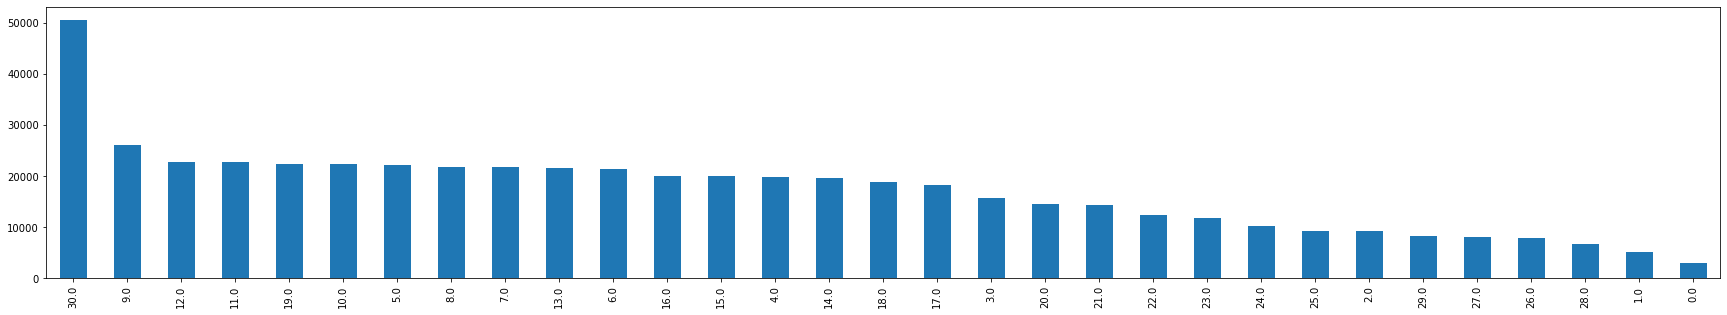

In [15]:
plt.figure(figsize = (30,5))
c = pd.DataFrame(d, columns = ["level"])
c.level = c.level//10
c.level.clip(0,30).value_counts().plot(kind = "bar")

In [16]:
c.level.max()

93.0

In [17]:
train

,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,...,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
0,1,2019-10-15T20:00:00+00:00,5.0.1,regular,standard,nawabari,sumeshi,sshooter_becchu,NaN,139,...,hokusai_becchu,NaN,26.0,splatcharger,NaN,68.0,sharp_neo,NaN,31.0,1
1,2,2019-12-14T04:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,parashelter_sorella,NaN,198,...,squiclean_b,NaN,118.0,campingshelter,NaN,168.0,sputtery_clear,NaN,151.0,0
2,3,2019-12-25T14:00:00+00:00,5.0.1,gachi,standard,hoko,ama,nzap89,a-,114,...,nzap85,a+,163.0,prime_becchu,a-,160.0,dualsweeper_custom,a,126.0,0
3,4,2019-11-11T14:00:00+00:00,5.0.1,regular,standard,nawabari,engawa,bamboo14mk1,NaN,336,...,liter4k,NaN,189.0,promodeler_mg,NaN,194.0,hotblaster_custom,NaN,391.0,0
4,5,2019-12-14T06:00:00+00:00,5.0.1,gachi,standard,hoko,chozame,bold_7,x,299,...,sputtery_hue,x,45.0,bucketslosher_soda,x,246.0,wakaba,x,160.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66120,66121,2019-10-11T10:00:00+00:00,5.0.1,gachi,standard,area,devon,hokusai_becchu,a,66,...,nzap85,a+,272.0,splatcharger,a,38.0,wakaba,a+,283.0,1
66121,66122,2019-12-04T00:00:00+00:00,5.0.1,gachi,standard,asari,otoro,hokusai_becchu,s+,204,...,prime_becchu,s+,167.0,pablo,s+,188.0,nzap89,s+,170.0,1
66122,66123,2019-10-22T00:00:00+00:00,5.0.1,gachi,standard,hoko,bbass,prime_collabo,a+,116,...,bold_neo,a+,70.0,nzap85,a+,191.0,hissen_hue,a+,139.0,1
66123,66124,2019-12-11T00:00:00+00:00,5.0.1,gachi,standard,area,fujitsubo,splatroller,s+,210,...,splatroller,s+,395.0,rapid_elite_deco,s+,223.0,sharp_neo,s+,194.0,0
